<a href="https://colab.research.google.com/github/deniseiras/trabalho_cap239_b/blob/master/RNN_To_COVID19_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Network Example Applied to COVID-19


---


Authors: Luis Ricardo and Marcos Rodrigues

National Institute For Space Research

Applied Computing Ph.D. Program  

Date: June 2020

Useful links:  
> [Introduction Programing for Remote Sensing - SER-347 - Jupyter Notebook?](https://ser-347.github.io/ipython_jupyter/jupyter_introd.html)  
> [Welcome To Colaboratory (Colab)](https://colab.research.google.com/notebooks/intro.ipynb#scrollTo=C4HZx7Gndbrh)  
> [What is Google Colab?](https://www.tutorialspoint.com/google_colab/what_is_google_colab.htm)  
> [Colaboratory - Frequently Asked Questions](https://research.google.com/colaboratory/faq.html)  
> [Colab - External data: Local Files, Drive, Sheets, and Cloud Storage](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=c2W5A2px3doP)

### Daily Cases of COVID in the Our World in Data:

Source: https://ourworldindata.org/covid-cases
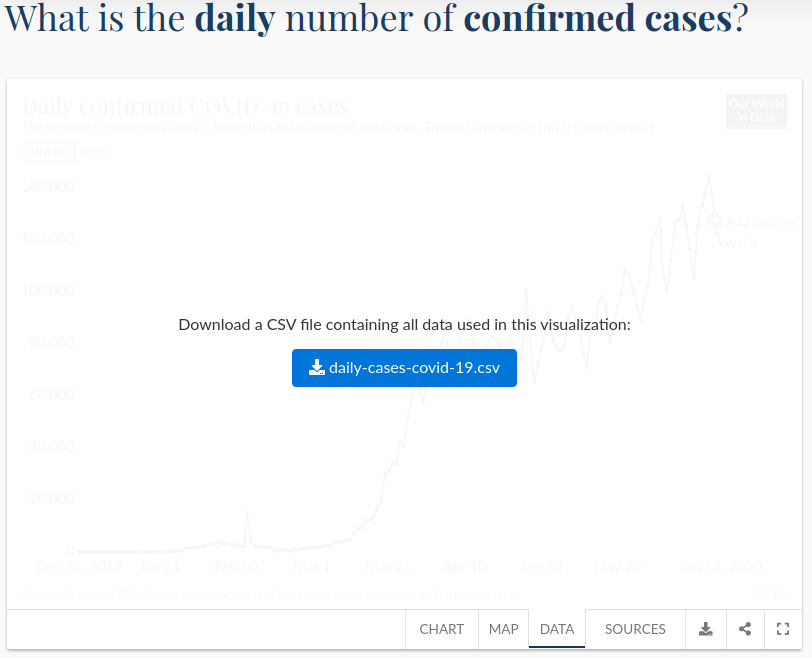

## Denis Tests


In [1]:
# Imports to read, manage and view data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!lsb_release -d

#CPU: 
!lscpu |grep 'Model name'

#no.of sockets i.e available slots for physical processors
!lscpu | grep 'Socket(s):'

#no.of cores each processor is having 
!lscpu | grep 'Core(s) per socket:'

#no.of threads each core is having
!lscpu | grep 'Thread(s) per core'

!lscpu | grep "L3 cache" 

#if it had turbo boost it would've shown Min and Max MHz also but it is only showing current frequency this means it always operates at 2.3GHz
!lscpu | grep "MHz"


#hard disk space that we can use
print('Disk ', end="")
!df -h / | awk '{print $4}'

#RAM:
print('RAM Avail: ', end="")
!free -h --si | awk  '/Mem:/{print $2}'

#GPU:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Description:	Ubuntu 18.04.3 LTS
Model name:          Intel(R) Xeon(R) CPU @ 2.00GHz
Socket(s):           1
Core(s) per socket:  1
Thread(s) per core:  2
L3 cache:            39424K
CPU MHz:             2000.152
Disk Avail
34G
RAM Avail: 13G
Wed Jun 17 22:28:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|      

### Get data from Google Drive via PyDrive

Source: [3 Ways to Load CSV files into Colab](https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92)

In [3]:
# Code to read csv file into Colaboratory:!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
link = 'https://drive.google.com/file/d/1eiMoDr1J2vMYmxSd4IgEc11sG6ReZZ7G' # The shareable link

id='1eiMoDr1J2vMYmxSd4IgEc11sG6ReZZ7G'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('daily-cases-covid-19.csv')
!mkdir Number_Daily_Cases
!mv daily-cases-covid-19.csv ./Number_Daily_Cases

In [6]:
!ls

adc.json  Number_Daily_Cases  sample_data


In [8]:
serie_cases = pd.read_csv('./Number_Daily_Cases/daily-cases-covid-19.csv',header = None)

### Manipulando as Estruturas de Dados

In [9]:
serie_cases.head()

,0,1,2,3
0,Entity,Code,Date,Daily confirmed cases (cases)
1,Afghanistan,AFG,"Dec 31, 2019",0
2,Afghanistan,AFG,"Jan 1, 2020",0
3,Afghanistan,AFG,"Jan 2, 2020",0
4,Afghanistan,AFG,"Jan 3, 2020",0


In [10]:
serie_cases.tail()

,0,1,2,3
21596,Zimbabwe,ZWE,"May 21, 2020",2
21597,Zimbabwe,ZWE,"May 22, 2020",3
21598,Zimbabwe,ZWE,"May 23, 2020",5
21599,Zimbabwe,ZWE,"May 24, 2020",0
21600,Zimbabwe,ZWE,"May 25, 2020",0


#### ANALISANDO UM PAIS

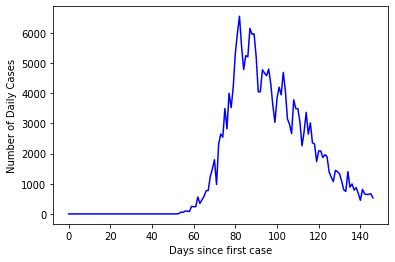

In [11]:
select_cases_pais = serie_cases[serie_cases[0] == 'Italy']
select_cases_pais = select_cases_pais[[0,2,3]]

pais_cases = select_cases_pais.iloc[:,2]
pais_days = select_cases_pais.iloc[:,1]

pais_cases = pais_cases.tolist()
pais_cases = np.asarray(pais_cases)
pais_cases = np.float64(pais_cases)
plt.plot(pais_cases,'b');
plt.xlabel('Days since first case');
plt.ylabel('Number of Daily Cases');

In [12]:
len(pais_cases)

147

### Define functions to build model and prepare data to training

In [15]:
import pandas as pd
import os
import matplotlib.pyplot as plt
# univariate data preparation
import numpy as np
from numpy import array
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM,Flatten
from keras import layers
from keras import models
from keras import optimizers
from keras.models import Sequential
from numpy import array 
from numpy import hstack 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math

path = os.getcwd()

def organizar_dados(path_input,tipo_analise,pais):
    path = os.path.join(path_input,tipo_analise)    
    list_files_analise = os.listdir(path)
    list_files_analise.sort()
    serie_analise = pd.read_csv(os.path.join(path,list_files_analise[0]),header = None)
    select_analise = serie_analise[serie_analise[0] == pais]
    
    select_analise = select_analise[[0,2,3]]
    
    return select_analise


#split a multivariate sequence into samples 

def split_sequences(sequences, n_steps_in, n_steps_out):
    '''
    Brownlee, J. (2018). Deep Learning for Time Series Forecasting: 
    Predict the Future with MLPs, CNNs and LSTMs in Python. 
    Machine Learning Mastery.
    '''
    X, y = list(), list() 
    for i in range(len(sequences)): 
        #find the end of this pattern 
        end_ix = i + n_steps_in 
        out_end_ix = end_ix + n_steps_out 
        #check if we are beyond the dataset 
        if out_end_ix > len(sequences): 
            break 
        #gather input and output parts of the pattern 
        seq_x, seq_y = sequences[i:end_ix], sequences[end_ix:out_end_ix] 
        X.append(seq_x) 
        y.append(seq_y) 
    return X, y

def preparar_dados(dados_covid, n_dias_entrada, n_dias_saida):    
    # choose a number of time steps 
    # covert into input/output
    dados_covid = dados_covid.iloc[:,2]
    dados_covid = np.float64(dados_covid.tolist())
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = dados_covid.reshape(-1, 1)
    data = scaler.fit_transform(data)
    data = data.reshape(len(data),)
    
    #lista_covid = dados_covid.tolist()
    X, y = split_sequences(data, n_dias_entrada, n_dias_saida)
    
    inputarray = data[-n_dias_entrada:]
    inputarray = [float(i) for i in inputarray]
    inputarray = np.asarray(inputarray)
#    X = [float(i) for i in X]
#    y = [float(i) for i in y]
    X = np.float64(X)
    y = np.float64(y)
#    lista_covid =  [float(i) for i in lista_covid]
#    lista_covid = np.asarray(lista_covid)
#    lista_covid = np.float64(lista_covid)
    
    return data, X,y, inputarray,scaler


def definir_modelo_lstm_simples(modelo,n_dias_entrada, n_dias_saida):
    n_features = 1
    modelo.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_dias_entrada, n_features)))
    modelo.add(LSTM(200, activation='relu'))
    modelo.add(Dense(n_dias_saida))
    
    modelo.compile(optimizer='adam', loss='mse')
    return modelo

def treinamento(X,y,modelo,epocas,batch):
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    # fit model
    history = modelo.fit(X, y, epochs=epocas,batch_size=batch)

    return history

def predict(modelo,inputarray,n_dias_entrada):
    n_features = 1
    x_input = inputarray
    x_input = x_input.reshape((1, n_dias_entrada, n_features))
    yhat = modelo.predict(x_input, verbose=0)
    
    y_future = np.asarray(yhat)
    y_future = yhat.ravel()
    y_future = np.float64(y_future)
    return y_future

def validacao(modelo,n_dias_entrada,inputarray):
    n_features = 1
    x_input = inputarray
    x_input = x_input.reshape((1, n_dias_entrada, n_features))
    yhat = modelo.predict(x_input, verbose=0)
    
    y_future = np.asarray(yhat)
    y_future = yhat.ravel()
    y_future = np.float64(y_future)
    
    return y_future

import pickle
import csv
   
def salvarmodelo(nome,modelo):
    #Salvando
    filename = nome+'.sav'
    pickle.dump(modelo, open(filename, 'wb'))
    

def salvardicionario(nome, history):
    #Salvando Dicionario
    w = csv.writer(open(nome+".csv", "w"))
    for key, val in history.items():
        w.writerow([key, val])    

def carregaModelo(nomeModelo):
    carrega_modelo = pickle.load(open(nomeModelo+'.sav', 'rb'))
    return carrega_modelo

In [16]:
'''
# =============================================================================
# Treinamento do modelo - 
# =============================================================================
'''

def gerarTreinamento_parametros(pais,version,n_entradas,n_saidas):
    #Parametros: (path_input,tipo_analise,pais)
    daily_cases = organizar_dados(str(os.getcwd()),"Number_Daily_Cases",pais)
    
    #Parametros: (dados_covid, n_dias_entrada, n_dias_saida) -- scaler - toback oringial data
    dados_covid, X,y, input_array, scaler = preparar_dados(daily_cases, n_entradas, n_saidas)
    
    ##Parametros: (modelo,n_dias_entrada, n_dias_saida)
    modelo = Sequential()
    modelo = definir_modelo_lstm_simples(modelo,n_entradas, n_saidas)
    
    #Parametros: (X,y,modelo,epocas,batch)
    history = treinamento(X,y,modelo,50,1)
    #cria dicionario
    history = history.history
    history.keys()
    
    #Salvando Dicionario
    salvardicionario("History_"+pais+"_"+version,history)
    salvarmodelo("Modelo_"+pais+"_"+version,modelo)

In [17]:

'''
# =============================================================================
# Treinamento dos modelos - paises
# =============================================================================
'''
#Parametros: pais,version,n_entradas,n_saidas    
gerarTreinamento_parametros("Italy","v1",20,10)
# gerarTreinamento_parametros("Portugal","v2",10,5)
# gerarTreinamento_parametros("Portugal","v3",10,7)
# gerarTreinamento_parametros("Portugal","v4",10,10)
# gerarTreinamento_parametros("Portugal","v5",15,10)
# gerarTreinamento_parametros("Portugal","v6",20,10)

Epoch 1/50
118/118 [==============================] - 10s 81ms/step - loss: 0.0786
Epoch 2/50
118/118 [==============================] - 8s 65ms/step - loss: 0.0426
Epoch 3/50
118/118 [==============================] - 8s 64ms/step - loss: 0.0326
Epoch 4/50
118/118 [==============================] - 8s 64ms/step - loss: 0.0187
Epoch 5/50
118/118 [==============================] - 8s 64ms/step - loss: 0.0139
Epoch 6/50
118/118 [==============================] - 8s 65ms/step - loss: 0.0120
Epoch 7/50
118/118 [==============================] - 8s 65ms/step - loss: 0.0083
Epoch 8/50
118/118 [==============================] - 8s 64ms/step - loss: 0.0064
Epoch 9/50
118/118 [==============================] - 8s 65ms/step - loss: 0.0069
Epoch 10/50
118/118 [==============================] - 8s 65ms/step - loss: 0.0056
Epoch 11/50
118/118 [==============================] - 8s 65ms/step - loss: 0.0051
Epoch 12/50
118/118 [==============================] - 8s 65ms/step - loss: 0.0064
Epoch 13/50


In [26]:
'''
# =============================================================================
# GERAR A VALIDAÇÃO DE SÉRIE INTEIRA AUTOMATICAMENTE
# =============================================================================
'''
def geraValidacao(pais,modelo,n_entrada,n_saida):
    daily_cases = organizar_dados(str(os.getcwd()),"Number_Daily_Cases",pais)
    dados_covid, X,y, input_array, scaler = preparar_dados(daily_cases, n_entrada, n_saida)
    
    print("len(dados_covid)", len(dados_covid))
    print("len(input_array)", len(input_array))
    #Carrega modelo já Treinado
    modelo = carregaModelo(modelo)
    
    list_pred = []
    for i in range(0, len(dados_covid), n_saida):
        input_array_test =  np.array(dados_covid[i:(i+n_entrada)])
        
        # ====== TEST DENIS ==============
        while len(input_array_test) < n_entrada:
           input_array_test = np.append(input_array_test,[0],axis = None)

        # if len(input_array_test) < n_entrada:
        #   input_array_test = np.append(input_array_test,[0],axis = None)
        
        y_predict_val_test = predict(modelo,input_array_test,n_entrada)
        list_pred.append(y_predict_val_test)
    
    plt.figure()
    concatenado = np.concatenate((list_pred[:]))
    true = dados_covid[n_entrada:len(concatenado)+n_entrada]
#    print(len(true))
#    print(len(concatenado))
    if len(true) < len(concatenado):
        print("entrou condi")
        lim = (len(concatenado) - len(true))
        concatenado = concatenado[0:len(concatenado) - lim]
        
    score_rmse = math.sqrt(mean_squared_error(concatenado, true))
    plt.plot(concatenado,'r--', label = 'Predicted Values')
    plt.plot(true,'b',label = 'True Values')
    plt.xlabel('Days Since First Case')
    plt.ylabel('Daily Confirmed Cases')
    plt.legend(loc ='upper right')
    plt.title('Prediction Score: %.4f RMSE' % (score_rmse))
    
    print("Prediction Score [RMSE]: ", score_rmse)
    return score_rmse


---------***-----Score Italy ------***--------
len(dados_covid) 147
len(input_array) 20
entrou condi
Prediction Score [RMSE]:  0.05462777324761975


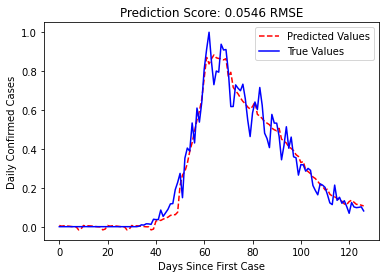

In [27]:
'''
Validação países
'''
print("---------***-----Score Italy ------***--------")
#modelo 1
#pontos de entrada
n_entrada = 20
#pontos de saida
n_saida = 10
#Parametros: (pais,modelo,n_entrada,n_saida,t,lim_pred,lim_true):
score_italy_1 = geraValidacao("Italy","Modelo_Italy_v1",n_entrada,n_saida)



Text(0.5, 1.0, 'Forecasting for Portugal Daily COVID-19 Cases, Next 5 days')

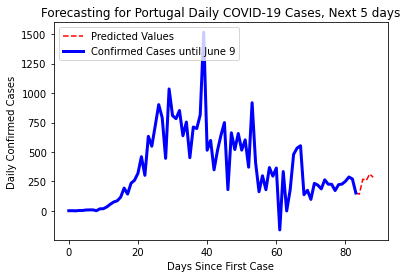

In [ ]:
'''
MODELO ESCOLHIDO PARA A PREDIÇÃO DE PONTOS FUTUROS
'''
plt.figure()
#Carrega modelo já Treinado
modelo = carregaModelo('Modelo_Portugal_v1')

#Parametros: (dados_covid, n_dias_entrada, n_dias_saida) -- scaler - toback original data
daily_cases = organizar_dados(str(os.getcwd()),"Number_Daily_Cases","Portugal")
dados_covid, X,y, input_array, scaler = preparar_dados(daily_cases, 5, 5)

input_array_2 =  np.array(dados_covid[79:84])

y_predict_val = predict(modelo,input_array_2,5)
predicted_serie = np.concatenate((dados_covid, y_predict_val))
predicted_serie_transform = scaler.inverse_transform(predicted_serie.reshape(len(predicted_serie),1))
dados_covid_transform = scaler.inverse_transform(dados_covid.reshape(len(dados_covid),1))

plt.plot(predicted_serie_transform,'r--',label = 'Predicted Values')
#plt.plot(dados_covid_transforma,'g',label = 'Updated Values')
plt.plot(dados_covid_transform,'b',label = 'Confirmed Cases until June 9',linewidth=3.0)

plt.xlabel('Days Since First Case')
plt.ylabel('Daily Confirmed Cases')
plt.legend(loc ='upper left')
plt.title('Forecasting for Portugal Daily COVID-19 Cases, Next 5 days')

## Web Scraping


---


### Painel COVID-19 - Voz das Comunidades
Fonte: https://painel.vozdascomunidades.com.br/

#### Painel de atualização de coronavírus nas favelas do Rio de Janeiro, feito pelo Voz das Comunidades. Os dados começaram a ser atualizados no dia 10/04/2020.

FONTE DAS INFORMAÇÕES SOBRE OS CASOS CONFIRMADOS E ÓBITOS CONFIRMADOS  
    - Prefeitura do Rio de Janeiro, Governo Estadual do Rio de Janeiro, Clínica da Família Zilda Arns, Clínica da Família Pavão-Pavãozinho e Cantagalo, Centro de Saúde Escola Germano Sinval Faria - ENSP, Clínica da família Victor Valla, Clínica da Família Maria do Socorro Silva e Souza, Clínica da Família Valter Felisbino de Souza, Unidade de Saúde da Familia João Candido, Clínica da Família Anthídio Dias da Silveira, Clínica da Família Rinaldo De Lamare, Cms Dr Albert Sabin e Comitê SOS Providência

FONTE DAS INFORMAÇÕES SOBRE OS RECUPERADOS   
    - Prefeitura do Rio de Janeiro


In [ ]:
# General Imports:
import re
import os
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [ ]:
# Imports and Functions used for Web Scrapping and save data
import requests
from bs4 import BeautifulSoup, NavigableString
import socket
import ast #to eval python expression from strings

#https://docs.python.org/3/howto/urllib2.html
# timeout in seconds
timeout = 10
socket.setdefaulttimeout(timeout)

#----------------------------------
# Functions
#----------------------------------

#About pickle - https://stackoverflow.com/a/19201448
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def html2accent(textcontent):
    
    htmlcodes = ['&ccedil', '&Ccedil', '\u00e9','\u00ea','\u00e3']
    funnychars = ['ç','Ç','é','ê','ã']
    
    for i,pathern in enumerate(htmlcodes):
        textcontent = re.sub(pathern, funnychars[i], textcontent)    
    
    return textcontent


If the access was successful: <Response [200]>
<Response [200]> 


Id: 0 Tag: 

Id: 1 Tag: 

Id: 2 Tag: 

Id: 3 Tag: var acumulados = {"datas":["22\/03","23\/03","24\/03","25\/04","26\/03","27\/03","28\/03","29\/03","30\/03","31\/03","01\/04","02\/04","03\/04","04\/04","05\/04","06\/04","07\/04","08\/04","09\/04","10\/04","11\/04","12\/04","13\/04","14\/04","15\/04","16\/04","17\/04","18\/04","19\/04","20\/04","21\/04","22\/04","23\/04","24\/04","25\/04","26\/04","27\/04","28\/04","29\/04","30\/04","01\/05","02\/05","03\/05","04\/05","05\/05","06\/05","07\/05","08\/05","09\/05","10\/05","11\/05","12\/05","13\/05","14\/05","15\/05","16\/05","17\/05","18\/05","19\/05","20\/05","21\/05","22\/05","23\/05","24\/05","25\/05","26\/05","27\/05","28\/05","29\/05","30\/05","31\/05","01\/06","02\/06","03\/06","04\/06","05\/06","07\/06","08\/06","09\/06","10\/06","11\/06","12\/06","13\/06","14\/06","15\/06","16\/06"],"confirmados":[1,1,1,1,1,4,4,4,4,4,6,6,7,10,16,16,21,32,37,51,52,63,69,71,75,77,7

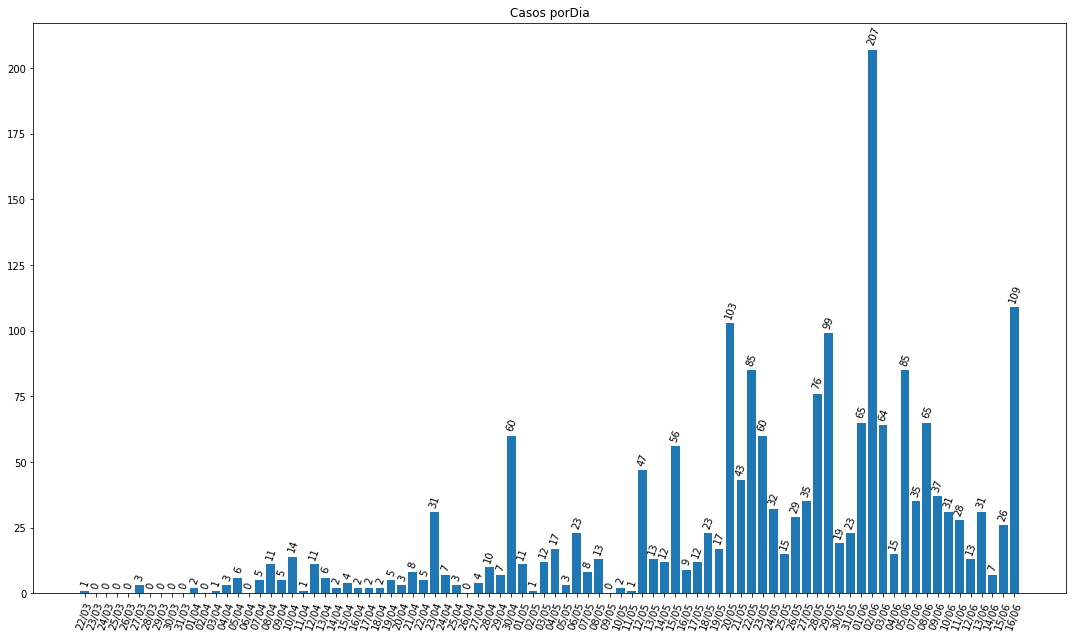

Dicionario:  comunidades

Id: 4 Tag: 

Id: 5 Tag: 

Id: 6 Tag: 

Id: 7 Tag: 

Id: 8 Tag: window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-164033848-2');


In [ ]:
# Set the URL you want to webscrape from
url = 'https://painel.vozdascomunidades.com.br' 

# Connect to the URL
response = requests.get(url)

print('If the access was successful: <Response [200]>')
print(response,'\n')

# Parse HTML and save to BeautifulSoup object
#soup = BeautifulSoup(response.text, "html.parser")
soup = BeautifulSoup(response.text, "lxml")

visualization = True
for id,tag in enumerate(soup.find_all("script", recursive=True)):
    
     print('\nId:',id,'Tag:',html2accent(tag.text.strip()))
     
     if 'porDia' in tag.text:
         for content in tag:
             name = content.name
             if isinstance(content, NavigableString):
                 s = html2accent(str(content))
                 s = s.replace("\n","")
                 s = s.replace("var ","")
                 s = s.replace("\\/","/")
                 s = s.replace('"24/03","25/04","26/03"','"24/03","25/03","26/03"') #Corrige bug date
                 values = s.strip().split(';')
                 values.remove('') #remove empty item
                 
                 for value in values:                     
                     var_name = value[:value.find('=')].strip()
                     print('Dicionario: ',var_name)
                     start = value.find('{')
                     end = value.find('}')
                     x = ast.literal_eval(value[start:end+1])
                     if "confirmados" in x:
                         x['confirmados'] = [int(i) for i in x['confirmados']]
                    
                     save_obj(x,var_name)   
                         
                     if visualization and var_name == 'porDia':
                         plt.xticks(rotation=70)
                         plt.bar(x['datas'], x['confirmados'], align='center')
                         plt.title('Casos '+var_name)

                         # Text on the top of each barplot
                         for i in range(len(x['datas'])):
                             if x['confirmados'][i] < 10:
                                 plt.text(x = i-0.5, y = x['confirmados'][i]+2, s = str(x['confirmados'][i]), rotation=70)
                             else:
                                 plt.text(x = i-0.6, y = x['confirmados'][i]+2, s = str(x['confirmados'][i]), rotation=70)
                            
                        
                         #plt.savefig("Casos_"+var_name+".png", dpi=100)
                         fig = plt.gcf()
                         fig.set_size_inches(18.5, 10.5)
                         plt.show()
                        #  fig.savefig("Casos_"+var_name+".png", dpi=100)
                         

#### Read dictionaries and convert to dataframe

In [ ]:
df_vozcom_final = pd.merge(pd.DataFrame(load_obj('porDia')),
                           pd.DataFrame(load_obj('acumulados')).rename(columns={'confirmados': 'confirmados_acum', 'obitos': 'obitos_acum'}),
                           on='datas')

In [ ]:
df_vozcom_final.head()

,datas,confirmados,confirmados_acum,obitos_acum
0,22/03,1,1,0
1,23/03,0,1,0
2,24/03,0,1,0
3,25/03,0,1,0
4,26/03,0,1,0


In [ ]:
'''
Analises das Comunidades
'''

comunidades_df = df_vozcom_final.iloc[:,0:2]
comunidades_df = comunidades_df.rename_axis('index').reset_index()

def gerarTreinamento_parametros_Comunidades(pais,version,n_entradas,n_saidas):
    #Parametros: (path_input,tipo_analise,pais)
    daily_cases = comunidades_df
    #Parametros: (dados_covid, n_dias_entrada, n_dias_saida) -- scaler - toback oringial data
    dados_covid, X,y, input_array, scaler = preparar_dados(daily_cases, n_entradas, n_saidas)
    
    ##Parametros: (modelo,n_dias_entrada, n_dias_saida)
    modelo = Sequential()
    modelo = definir_modelo_lstm_simples(modelo,n_entradas, n_saidas)
    
    #Parametros: (X,y,modelo,epocas,batch)
    history = treinamento(X,y,modelo,50,1)
    #cria dicionario
    history = history.history
    history.keys()
    
    #Salvando Dicionario
    salvardicionario("History_"+pais+"_"+version,history)
    salvarmodelo("Modelo_"+pais+"_"+version,modelo)


In [ ]:
'''
# =============================================================================
# COMUNIDADES DO RIO DE JANEIRO
# =============================================================================
'''

gerarTreinamento_parametros_Comunidades("Comunidades","v1",5,5)

Epoch 1/50
77/77 [==============================] - 4s 49ms/step - loss: 0.0247
Epoch 2/50
77/77 [==============================] - 2s 22ms/step - loss: 0.0219
Epoch 3/50
77/77 [==============================] - 2s 21ms/step - loss: 0.0204
Epoch 4/50
77/77 [==============================] - 2s 22ms/step - loss: 0.0200
Epoch 5/50
77/77 [==============================] - 2s 22ms/step - loss: 0.0200
Epoch 6/50
77/77 [==============================] - 2s 22ms/step - loss: 0.0195
Epoch 7/50
77/77 [==============================] - 2s 22ms/step - loss: 0.0195
Epoch 8/50
77/77 [==============================] - 2s 22ms/step - loss: 0.0195
Epoch 9/50
77/77 [==============================] - 2s 22ms/step - loss: 0.0187
Epoch 10/50
77/77 [==============================] - 2s 22ms/step - loss: 0.0190
Epoch 11/50
77/77 [==============================] - 2s 22ms/step - loss: 0.0179
Epoch 12/50
77/77 [==============================] - 2s 22ms/step - loss: 0.0186
Epoch 13/50
77/77 [==================

---------***-----Score Comuniadades ------***--------
Prediction Score [RMSE]:  0.1173726727323688


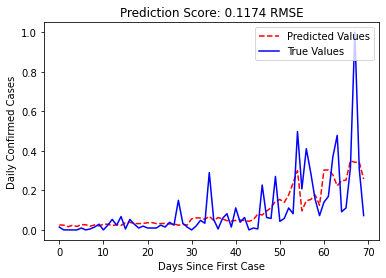

In [ ]:
def geraValidacao_Comunidades(pais,modelo,n_entrada,n_saida,comunidade):
    daily_cases = comunidade
    dados_covid, X,y, input_array, scaler = preparar_dados(daily_cases, n_entrada, n_saida)
    
    #Carrega modelo já Treinado
    modelo = carregaModelo(modelo)
    
    list_pred = []
    for i in range(0, 70, n_saida):
        input_array_test =  np.array(dados_covid[i:(i+n_entrada)])
        y_predict_val_test = predict(modelo,input_array_test,n_entrada)
        list_pred.append(y_predict_val_test)
    
    plt.figure()
    concatenado = np.concatenate((list_pred[:]))
    true = dados_covid[n_entrada:len(concatenado)+n_entrada]
#    print(len(true))
#    print(len(concatenado))
    if len(true) < len(concatenado):
        print("entrou condi")
        lim = (len(concatenado) - len(true))
        concatenado = concatenado[0:len(concatenado) - lim]
        
    score_rmse = math.sqrt(mean_squared_error(concatenado, true))
    plt.plot(concatenado,'r--', label = 'Predicted Values')
    plt.plot(true,'b',label = 'True Values')
    plt.xlabel('Days Since First Case')
    plt.ylabel('Daily Confirmed Cases')
    plt.legend(loc ='upper right')
    plt.title('Prediction Score: %.4f RMSE' % (score_rmse))
    
    print("Prediction Score [RMSE]: ", score_rmse)
    return score_rmse
    
'''
Validação Comunidades
'''
print("---------***-----Score Comuniadades ------***--------")
#modelo 1
#pontos de entrada
n_entrada = 5
#pontos de saida
n_saida = 5
#Parametros: (pais,modelo,n_entrada,n_saida,t,lim_pred,lim_true):
score_comunidade_1 = geraValidacao_Comunidades("Comunidades","Modelo_Comunidades_v1",n_entrada,n_saida,comunidades_df)
